# 02-Space Stretching

In [1]:
import torch
import torch.nn as nn
from res.plot_lib import set_default, show_scatterplot, plot_bases
import matplotlib.pyplot as plt

In [11]:
set_default(figsize=(3, 3))

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
n_points = 1000

X = torch.randn(n_points, 2).to(device)

In [6]:
colors = X[:, 0]

In [8]:
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)

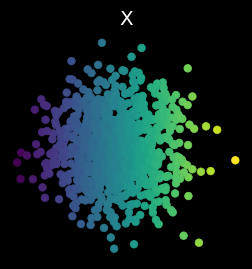

In [12]:
show_scatterplot(X, colors, title='X')

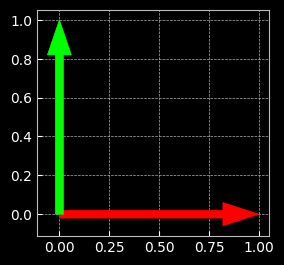

In [13]:
plot_bases(OI)

In [30]:
X.shape

torch.Size([1000, 2])

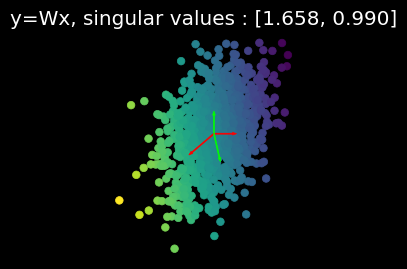

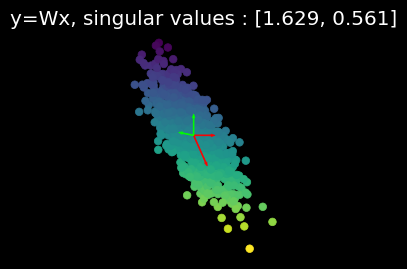

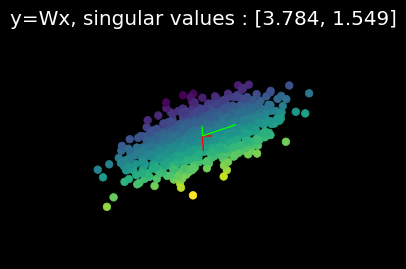

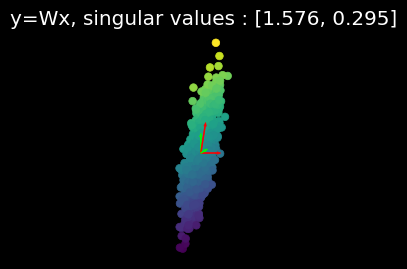

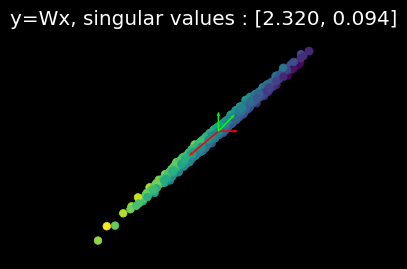

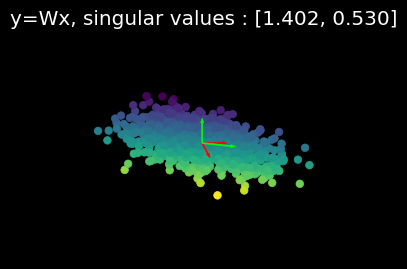

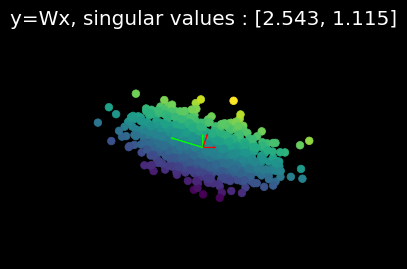

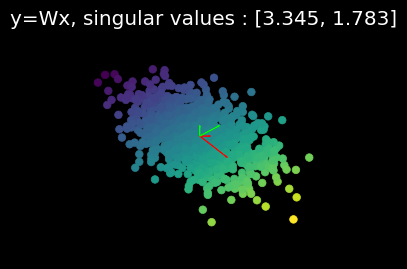

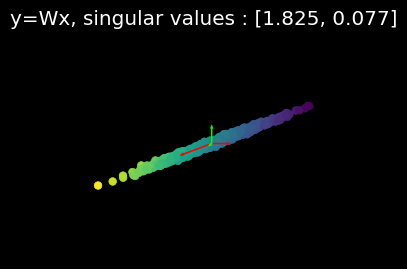

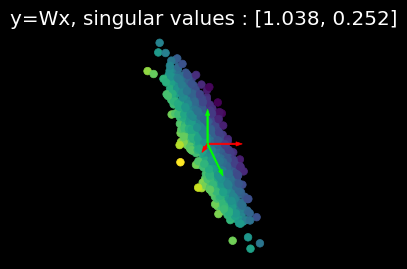

In [36]:
for i in range(10):
    W = torch.randn(2, 2).to(device)
    Y = X @ W.t()
    U, S, V = torch.svd(W)
    show_scatterplot(Y, colors, title='y=Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    new_OI = OI @ W.t()
    plot_bases(OI)
    plot_bases(new_OI)

In [16]:
W = torch.randn(2, 2).to(device)

In [20]:
W

tensor([[0.3091, 1.4202],
        [1.8834, 0.6808]])

# 01-tensor tutorial

In [1]:
import torch

In [5]:
t = torch.Tensor(2, 3, 4)

In [6]:
t.size()

torch.Size([2, 3, 4])

In [7]:
t.random_(10)

tensor([[[4., 0., 6., 1.],
         [0., 3., 4., 9.],
         [6., 6., 4., 2.]],

        [[3., 0., 8., 6.],
         [2., 5., 9., 1.],
         [7., 5., 1., 6.]]])

In [8]:
r = torch.Tensor(t)

##### Vectors(1D Tensors)

In [19]:
v = torch.Tensor([1, 2, 3, 4])

In [20]:
w = torch.Tensor([1, 0, 2, 0])

In [22]:
w @ v

tensor(7.)

In [27]:
v * w

tensor([1., 0., 6., 0.])

In [28]:
x = torch.Tensor(5).random_(10)

In [30]:
x[1:2 + 1]

tensor([2., 8.])

# 00

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

In [2]:
a = np.array([[0, 0]])
b = np.array([[0, 1]])
c = np.array([[1, 1]])
d = np.array([[1, 0]])

In [3]:
a = np.array([[0, 1, 1, 0],
              [0, 1, 0, 1]])

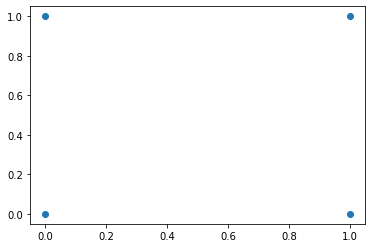

In [4]:
plt.scatter(a[0], a[1])

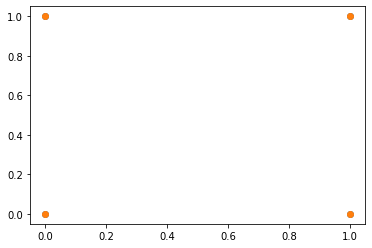

In [5]:
w = np.array(
    [[1, 0],
     [0, 1]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

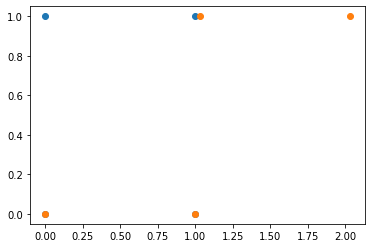

In [6]:
w = np.array(
    [[1, 1.03],
     [0, 1]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

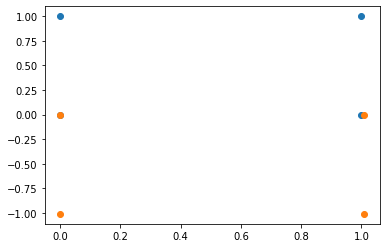

In [7]:
w = np.array(
    [[0, 1.01],
     [-1.01, 0]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

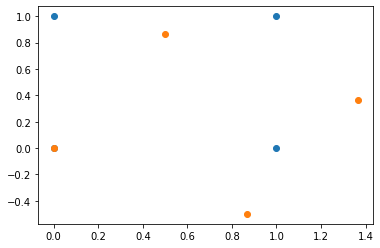

In [11]:
rad = -30/360 * 2 * np.pi
w = np.array(
    [[np.cos(rad), -np.sin(rad)],
     [np.sin(rad), np.cos(rad)]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

# Playing with translation and rotation

(-5.0, 5.0)

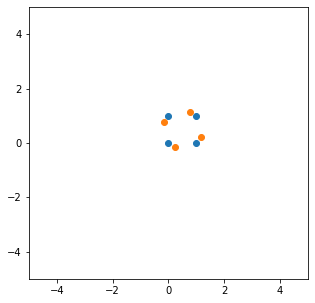

In [14]:

# w = np.array(
#     [[np.cos(rad), -np.sin(rad)],
#      [np.sin(rad), np.cos(rad)]]
# )
plt.figure(figsize=(5, 5))
t = np.append(a, np.ones((1, a.shape[1])), axis=0)
x_trans = 0
y_trans = 0
trans = np.array([
    [1, 0, -.5],
    [0, 1, -.5],
    [0, 0, 1]
])
rad = .4
rotate = np.array([
    [np.cos(rad), -np.sin(rad), 0],
    [np.sin(rad),  np.cos(rad), 0],
    [          0,            0, 1]
])
inv_trans = np.array([
    [1, 0, .5],
    [0, 1, .5],
    [0, 0, 1]
])
res = inv_trans.dot(rotate.dot(trans.dot(t)))
# another = inv_trans.dot(rotate.dot(trans.dot(t)))
plt.scatter(t[0], t[1])
plt.scatter(res[0], res[1])
# plt.scatter(another[0] + .01, another[1] + .01)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Eigen Values and SVD

In [69]:
a = np.array([
    [2, 2],
    [-2, 1]
])

In [70]:
vals, vecs = np.linalg.eig(a)

vecs

array([[ 0.70710678+0.j       ,  0.70710678-0.j       ],
       [-0.1767767 +0.6846532j, -0.1767767 -0.6846532j]])

/Users/rglamber/repos/pytorch-Deep-Learning/.env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


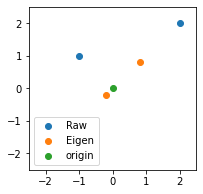

In [30]:
plt.figure(figsize=(3, 3))
plt.scatter(a[:, 0], a[:, 1], label='Raw')
plt.scatter(vecs[:, 0], vecs[:, 1], label='Eigen')
plt.scatter([0], [0], label='origin')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.legend()